# Notebook 3: Fine-Tuning (Ajuste Fino) do Modelo VGG16

**Objetivo:** Carregar o nosso melhor modelo VGG16 treinado anteriormente e aplicar a técnica de fine-tuning. Vamos "descongelar" as camadas finais do VGG16 e continuar o treinamento com uma taxa de aprendizado muito baixa para especializar o modelo no nosso dataset e tentar quebrar a barreira de 60% de acurácia.

### Passo 1: Setup Completo do Ambiente

Esta primeira célula cuidará de toda a configuração necessária. Ela irá:
1.  **Montar seu Google Drive:** Certifique-se de autorizar com a nova conta que possui cota de GPU.
2.  **Pedir o upload do `kaggle.json`:** Para configurar a API do Kaggle.
3.  **Baixar e descompactar o dataset de emoções.**
4.  **Criar os `DataFrames` e os geradores de imagem** no formato correto para o VGG16 (96x96, RGB).

In [1]:
# Célula 1: Setup Completo do Ambiente
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Montar Google Drive
print("--- Montando o Google Drive... ---")
drive.mount('/content/drive')

# 2. Configurar API do Kaggle
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("\n--- Por favor, faça o upload do seu arquivo kaggle.json ---")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nAPI do Kaggle configurada.")

# 3. Baixar e Descompactar o Dataset
if not os.path.exists('processed_data'):
    print("\n--- Baixando e descompactando o dataset ---")
    !kaggle datasets download -d fahadullaha/facial-emotion-recognition-dataset -p /content/ --unzip
    print("\nDataset pronto.")

# 4. Preparar DataFrames e Geradores
DATASET_BASE_DIR = 'processed_data' if os.path.exists('processed_data') else 'train'
filepaths, labels = [], []
folds = os.listdir(DATASET_BASE_DIR)
for fold in folds:
    foldpath = os.path.join(DATASET_BASE_DIR, fold)
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])

IMG_SIZE_VGG = (96, 96)
BATCH_SIZE = 64

train_datagen_vgg = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, horizontal_flip=True)
valid_datagen_vgg = ImageDataGenerator(rescale=1./255)

train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label', target_size=IMG_SIZE_VGG,
    color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE
)
valid_generator_vgg = valid_datagen_vgg.flow_from_dataframe(
    dataframe=valid_df, x_col='filepath', y_col='label', target_size=IMG_SIZE_VGG,
    color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

print("\nSetup completo! Ambiente e geradores de dados prontos.")

--- Montando o Google Drive... ---
Mounted at /content/drive

--- Por favor, faça o upload do seu arquivo kaggle.json ---


Saving kaggle.json to kaggle.json

API do Kaggle configurada.

--- Baixando e descompactando o dataset ---
Dataset URL: https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 70% 141M/200M [00:00<00:00, 1.48GB/s]
100% 200M/200M [00:00<00:00, 689MB/s] 

Dataset pronto.
Found 39823 validated image filenames belonging to 7 classes.
Found 9956 validated image filenames belonging to 7 classes.

Setup completo! Ambiente e geradores de dados prontos.


### Passo 2: Carregar o Modelo e Preparar para o Fine-Tuning

Agora carregamos nosso melhor modelo VGG16 do Google Drive. Em seguida, "descongelamos" o último bloco convolucional (`block5`), permitindo que seus pesos sejam ajustados durante a próxima fase de treinamento.

In [2]:
# Célula 2: Carregar e descongelar o modelo
from tensorflow.keras.models import load_model

# Carregue o modelo que salvamos na etapa anterior
MODEL_PATH = '/content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_final.keras'
model = load_model(MODEL_PATH)

# Acessa o VGG16, que é a primeira camada do nosso modelo sequencial
base_model = model.layers[0]
base_model.trainable = True

# Congela as camadas iniciais (blocos 1 a 4)
for layer in base_model.layers[:15]:
    layer.trainable = False

print("--- Status de Treinamento das Camadas para Fine-Tuning ---")
for layer in base_model.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

--- Status de Treinamento das Camadas para Fine-Tuning ---
input_layer: Trainable = False
block1_conv1: Trainable = False
block1_conv2: Trainable = False
block1_pool: Trainable = False
block2_conv1: Trainable = False
block2_conv2: Trainable = False
block2_pool: Trainable = False
block3_conv1: Trainable = False
block3_conv2: Trainable = False
block3_conv3: Trainable = False
block3_pool: Trainable = False
block4_conv1: Trainable = False
block4_conv2: Trainable = False
block4_conv3: Trainable = False
block4_pool: Trainable = False
block5_conv1: Trainable = True
block5_conv2: Trainable = True
block5_conv3: Trainable = True
block5_pool: Trainable = True


### Passo 3: Recompilar e Iniciar o Fine-Tuning

Após alterar a propriedade `trainable`, é **obrigatório** recompilar o modelo. Usamos uma taxa de aprendizado (`learning_rate`) muito baixa (`1e-5`) para fazer apenas ajustes "cirúrgicos" nos pesos do VGG16, sem destruir o conhecimento pré-treinado.

In [3]:
# Célula 3: Recompilar e treinar
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

# Recompilar com taxa de aprendizado baixa
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calcular pesos de classe (ainda uma boa prática)
class_weights_balanced = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_df['label']), y=train_df['label']
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_balanced)}

# Callbacks para o fine-tuning
DRIVE_SAVE_PATH = '/content/drive/MyDrive/Emotion_Recognition_Project/'
finetuned_model_filepath = os.path.join(DRIVE_SAVE_PATH, 'emotion_model_vgg_finetuned.keras')

early_stopping_ft = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint_ft = ModelCheckpoint(
    filepath=finetuned_model_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

print("\n--- Iniciando a fase de Fine-Tuning ---")
history_fine_tune = model.fit(
    train_generator_vgg,
    epochs=50,
    validation_data=valid_generator_vgg,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_ft, model_checkpoint_ft]
)


--- Iniciando a fase de Fine-Tuning ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5637 - loss: 1.1760
Epoch 1: val_accuracy improved from -inf to 0.58688, saving model to /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned.keras
623/623 ━━━━━━━━━━━━━━━━━━━━ 157s 235ms/step - accuracy: 0.5637 - loss: 1.1760 - val_accuracy: 0.5869 - val_loss: 1.0916
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5783 - loss: 1.1348
Epoch 2: val_accuracy improved from 0.58688 to 0.60084, saving model to /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned.keras
623/623 ━━━━━━━━━━━━━━━━━━━━ 136s 218ms/step - accuracy: 0.5783 - loss: 1.1348 - val_accuracy: 0.6008 - val_loss: 1.0678
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5934 - loss: 1.1060
Epoch 3: val_accuracy improved from 0.60084 to 0.60456, saving model to /content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned.keras
623/623 ━━━━━━━━━━━━━━━━━━

### Passo 4: Avaliação Final e Salvamento do Resumo do Fine-Tuning

Após a conclusão da fase de fine-tuning, esta célula irá realizar a análise de performance final. Além de gerar os gráficos e relatórios, ela criará um **novo arquivo JSON** (`training_summary_vgg_finetuned.json`) para documentar especificamente os resultados e parâmetros desta etapa, incluindo a baixa taxa de aprendizado utilizada.

--- Curvas de Aprendizado da Fase de Fine-Tuning ---


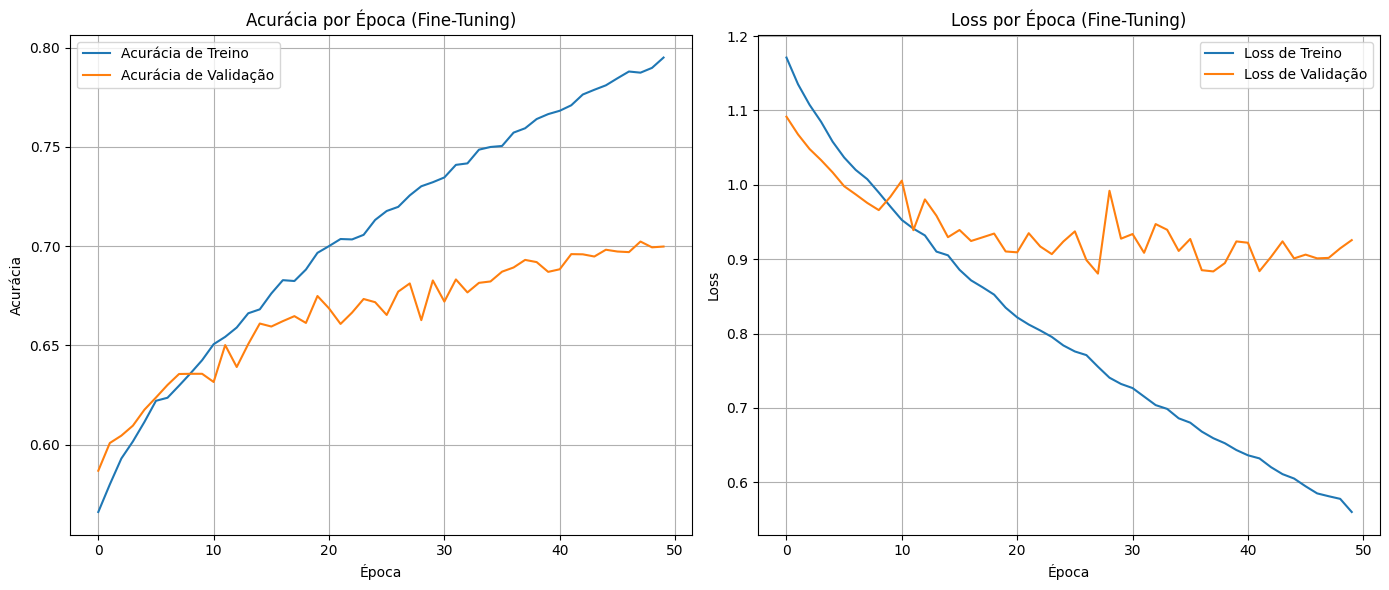


--- Fazendo predições com o modelo final... ---
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step

--- Relatório de Classificação Final (Pós Fine-Tuning) ---
              precision    recall  f1-score   support

       angry       0.65      0.50      0.57      1184
     disgust       0.93      0.86      0.89      1184
        fear       0.60      0.49      0.54      1184
       happy       0.84      0.86      0.85      2280
     neutral       0.57      0.72      0.64      1633
         sad       0.55      0.56      0.56      1307
    surprise       0.74      0.78      0.76      1184

    accuracy                           0.70      9956
   macro avg       0.70      0.68      0.69      9956
weighted avg       0.71      0.70      0.70      9956


--- Matriz de Confusão Final (Pós Fine-Tuning) ---


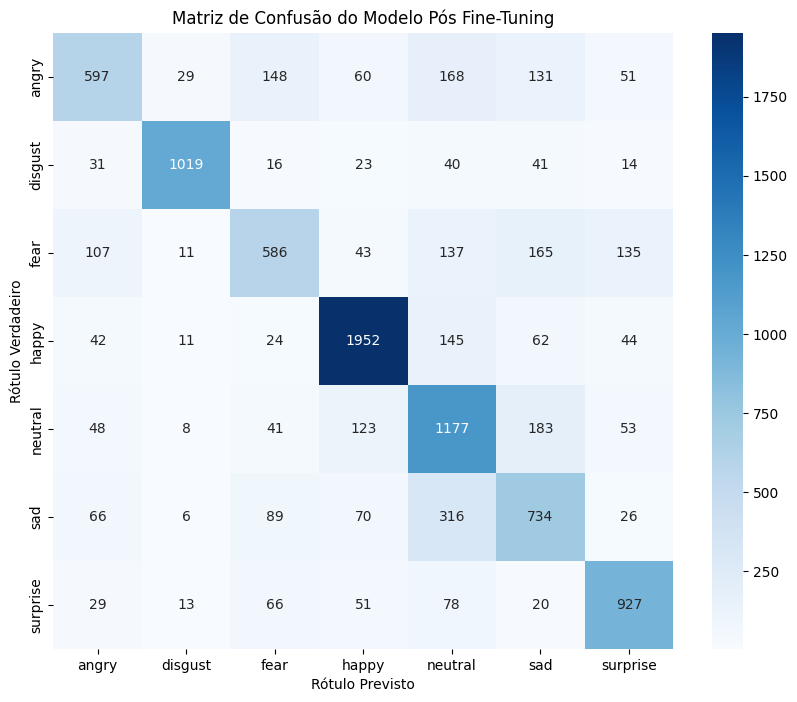

In [6]:
# Célula de Avaliação (VERSÃO CORRIGIDA)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Carregamos o melhor modelo que foi salvo pelo ModelCheckpoint durante o fine-tuning
final_model = load_model(finetuned_model_filepath)


# --- 1. AVALIAÇÃO VISUAL DO FINE-TUNING (CORRIGIDO) ---
print("--- Curvas de Aprendizado da Fase de Fine-Tuning ---")
history_df_ft = pd.DataFrame(history_fine_tune.history)

# Criamos a figura com 2 subplots lado a lado
plt.figure(figsize=(14, 6))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history_df_ft['accuracy'], label='Acurácia de Treino')
plt.plot(history_df_ft['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia por Época (Fine-Tuning)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(history_df_ft['loss'], label='Loss de Treino')
plt.plot(history_df_ft['val_loss'], label='Loss de Validação')
plt.title('Loss por Época (Fine-Tuning)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# --- 2. AVALIAÇÃO NUMÉRICA FINAL ---
print("\n--- Fazendo predições com o modelo final... ---")
predictions_ft = final_model.predict(valid_generator_vgg)
predicted_classes_ft = np.argmax(predictions_ft, axis=1)
true_classes_ft = valid_generator_vgg.classes
class_labels_ft = list(valid_generator_vgg.class_indices.keys())

print("\n--- Relatório de Classificação Final (Pós Fine-Tuning) ---")
print(classification_report(true_classes_ft, predicted_classes_ft, target_names=class_labels_ft))

print("\n--- Matriz de Confusão Final (Pós Fine-Tuning) ---")
cm_ft = confusion_matrix(true_classes_ft, predicted_classes_ft)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_ft, yticklabels=class_labels_ft)
plt.title('Matriz de Confusão do Modelo Pós Fine-Tuning')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()

### Passo 5: Salvar e Arquivar o Modelo Fine-Tuned no Drive

Agora vamos arquivar os resultados do nosso bem-sucedido fine-tuning. Esta célula irá:
1.  Confirmar que o melhor modelo foi salvo pelo `ModelCheckpoint`.
2.  Criar um arquivo JSON detalhado com as métricas, parâmetros e o histórico completo desta fase de treinamento.
3.  Salvar este arquivo JSON na mesma pasta do Google Drive, para que tenhamos o modelo e seus dados de performance juntos.

In [7]:
# Célula 5: Salvar o resumo do Fine-Tuning no Drive
import json
import pandas as pd
import numpy as np
import os

# A variável 'finetuned_model_filepath' foi definida na célula de treinamento
# e aponta para o local onde o ModelCheckpoint salvou o melhor modelo.
if os.path.exists(finetuned_model_filepath):
    print(f"Confirmação: O melhor modelo do fine-tuning já está salvo em:\n{finetuned_model_filepath}")
else:
    print("AVISO: O arquivo do modelo checkpoint não foi encontrado. Salvando o estado atual do modelo.")
    model.save(finetuned_model_filepath)


# --- EXTRAÇÃO DO JSON DE FINE-TUNING ---
print("\n--- Gerando e salvando o resumo do Fine-Tuning... ---")

# A variável 'DRIVE_SAVE_PATH' também foi definida na célula de treinamento
summary_filename_ft = 'training_summary_vgg_finetuned.json'
summary_filepath_ft = os.path.join(DRIVE_SAVE_PATH, summary_filename_ft)

class_indices_map = {v: k for k, v in valid_generator_vgg.class_indices.items()}
best_epoch_ft = np.argmax(history_fine_tune.history['val_accuracy'])
best_val_accuracy_ft = np.max(history_fine_tune.history['val_accuracy'])

# Criando o dicionário com as informações do fine-tuning
finetuning_summary = {
    "model_name": "FacialEmotionRecognition_VGG16_FineTuned_v2",
    "saved_model_path": finetuned_model_filepath,
    "based_on_model": MODEL_PATH, # O modelo que usamos como base para o fine-tune
    "timestamp": pd.to_datetime('now').isoformat(),
    "training_phase": "Fine-Tuning",
    "training_parameters": {
        "learning_rate": 1e-5,
        "unfrozen_layers": "block5 do VGG16",
        "total_epochs_run": len(history_fine_tune.history['accuracy'])
    },
    "final_metrics": {
        "best_validation_accuracy": float(best_val_accuracy_ft)
    },
    "class_map": class_indices_map,
    "fine_tuning_history": {k: [float(val) for val in v] for k, v in history_fine_tune.history.items()}
}

with open(summary_filepath_ft, 'w') as f:
    json.dump(finetuning_summary, f, indent=4)

print(f"\nSumário do fine-tuning salvo com sucesso em: {summary_filepath_ft}")
print("\nOperação concluída! O modelo e o resumo do treinamento estão seguros no seu Google Drive.")

Confirmação: O melhor modelo do fine-tuning já está salvo em:
/content/drive/MyDrive/Emotion_Recognition_Project/emotion_model_vgg_finetuned.keras

--- Gerando e salvando o resumo do Fine-Tuning... ---

Sumário do fine-tuning salvo com sucesso em: /content/drive/MyDrive/Emotion_Recognition_Project/training_summary_vgg_finetuned.json

Operação concluída! O modelo e o resumo do treinamento estão seguros no seu Google Drive.
